In [2]:
%load_ext autoreload
%autoreload 2
import logging
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from dnafiber.deployment import run_one_file, ENSEMBLE, Models
from dnafiber.inference import _get_model

for name, l in logging.root.manager.loggerDict.items():
    if "streamlit" in name:
        l.disabled = True

# Deactivate pandas FutureWarning
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
Models.UNET_MOBILEONE_S0

<Models.UNET_MOBILEONE_S0: 'unet_mobileone_s0'>

In [4]:
root = Path("/home/clement/Documents/data/DNAFiber/Input/")
output = Path("/home/clement/Documents/data/DNAFiber/OutputEnsembleV2/")
output.mkdir(exist_ok=True, parents=True) 
all_files = list(root.rglob("*.czi"))
for file in tqdm(all_files, total=len(all_files)):
    path_from_input = file.relative_to(root)
    output_file = output / path_from_input.with_suffix(".csv")
    if output_file.exists():
        continue  # Skip if the output file already exists
    df = run_one_file(file, model=ENSEMBLE, verbose=True, use_tta=False).to_df(img_name=file.stem, filter_invalid=False)
    output_file.parent.mkdir(exist_ok=True, parents=True)
    df.to_csv(output_file, index=False)

100%|██████████| 248/248 [00:00<00:00, 22822.64it/s]


In [5]:

palette = ["#81c8be", "#ef9f76"]

In [6]:
import matplotlib.pyplot as plt
from experiments import exp1, exp2, exp3, exp4, exp5

root = Path("/home/clement/Documents/data/DNAFiber/OutputEnsembleV2/YM-2025-20/")


df1, pairs1 = exp1("OutputEnsembleV2/YM-2025-20/", "YM-2025-20.xlsx")
df2, pairs2 = exp2("OutputEnsembleV2/YM-2025-16/", "YM-2025-16.xlsx")
df3, pairs3 = exp3("OutputEnsembleV2/YM-2025-17/", "YM-2025-17.xlsx")
df4, pairs4 = exp4("OutputEnsembleV2/YM-2025-21-22/", ["YM-2025-21.xlsx", "YM-2025-22.xlsx"])
df5, pairs5 = exp5("OutputEnsembleV2/YM-2025-25/", "YM-2025-25.xlsx")

['siBRCA2_12.5' 'si53BP1_5' 'siNT' 'si53BP1_7.5' 'siBRCA2_7.5'
 'si53BP1_12.5' 'siBRCA2_5']


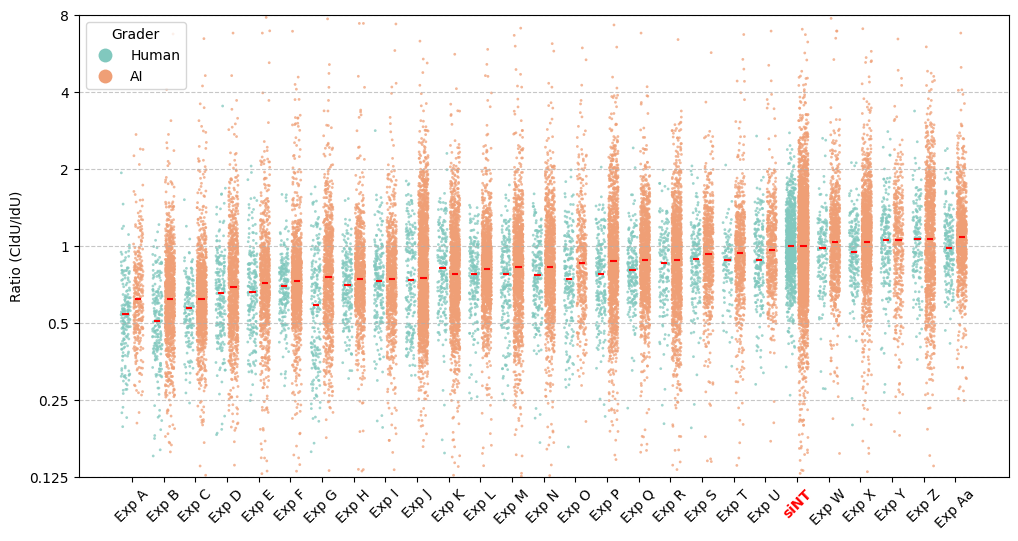

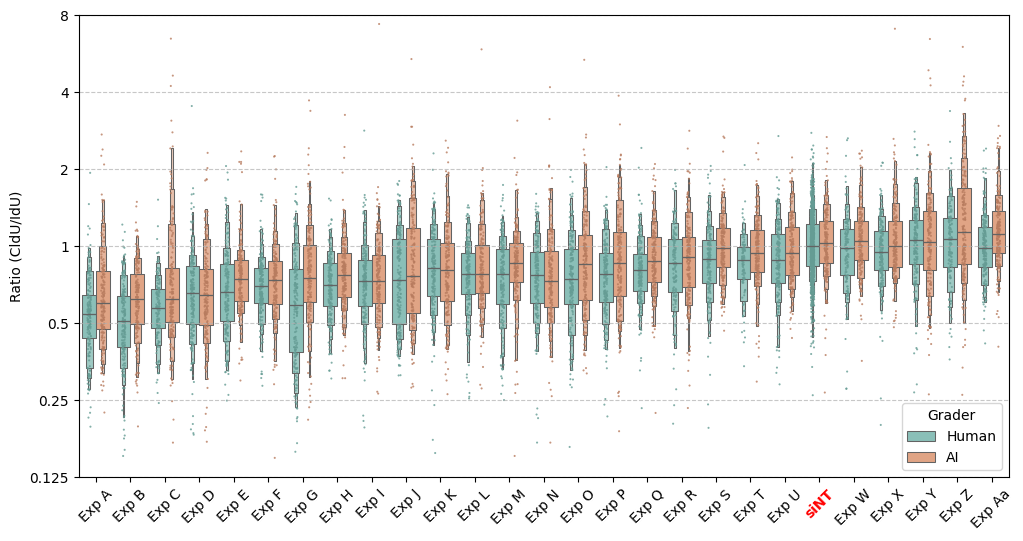

In [83]:
from dnafiber.analysis.ratios import create_boxen_plot, normalize_df, graders_statistical_test, compare_pairs, create_swarm_plot, select_N_closest_to_mean
import string
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
fig, ax = plt.subplots(figsize=(12, 6))


normalize_df(df, 'siNT')
# Relabel the type to anonymous labels (e.g., 'A', 'B', 'C' etc.)
alphabet = list(string.ascii_uppercase) + [a + b for a in string.ascii_uppercase for b in string.ascii_lowercase]


df = df[df['Ratio'] < 8]
df = df[df['Ratio'] > 0.125]
df = df[df['Valid']]




# Reorder the 'Type' categories based on the median 'Ratio' values
type_order = df.groupby('Type')['Ratio'].median().sort_values().index
df['Type'] = pd.Categorical(df['Type'], categories=type_order, ordered=True)
type_mapping = {original_type: f"Exp {alphabet[i]}" for i, original_type in enumerate((df['Type'].cat.categories)) if original_type != 'siNT'}
type_mapping['siNT'] = 'siNT'
df['Type'] = df['Type'].map(type_mapping)
create_swarm_plot(
    df,
    palette=palette,
    rotate_xticks=45,
    yrange=(0.125, 8),
    stripplot=True,
    alpha=0.75,
    dodge=True,
    size=2,
    jitter=0.3
)

# Change the color of the siNT xtick label to red
xticks = plt.gca().get_xticklabels()
for xtick in xticks:
    if xtick.get_text() == 'siNT':
        xtick.set_color('red')
        xtick.set_fontweight('bold')

# Remove the alpha from the legend markers
handles, labels = plt.gca().get_legend_handles_labels()
for handle in handles:
    handle.set_alpha(1)
    # Increase the size of the legend markers
    if hasattr(handle, "set_sizes"):
        handle.set_sizes([10])
    elif hasattr(handle, "set_markersize"):
        handle.set_markersize(10)
plt.legend(handles, labels, title="Grader", loc='upper left')
plt.ylabel("Ratio (CldU/IdU)")
plt.show()

df_select = select_N_closest_to_mean(df, N=None, column="Length")
plt.figure(figsize=(12, 6))

create_boxen_plot(
    df_select,
    palette=palette,
    rotate_xticks=45,
    yrange=(0.125, 8),
    alpha=1.0, showfliers=False
)
create_swarm_plot(
    df_select,
    include_median=False,
    palette=["#659c94", "#b87c5f"],
    rotate_xticks=45,
    yrange=(0.125, 8),
    stripplot=True,
    alpha=0.8,
    dodge=True,
    size=1.5,
    jitter=0.1,
    #
    legend=False
)

# Change the color of the siNT xtick label to red
xticks = plt.gca().get_xticklabels()
for xtick in xticks:
    if xtick.get_text() == 'siNT':
        xtick.set_color('red')
        xtick.set_fontweight('bold')


plt.ylabel("Ratio (CldU/IdU)")
plt.show()

In [ ]:
len(df[df['Grader']=="AI"]['Type'])

30756

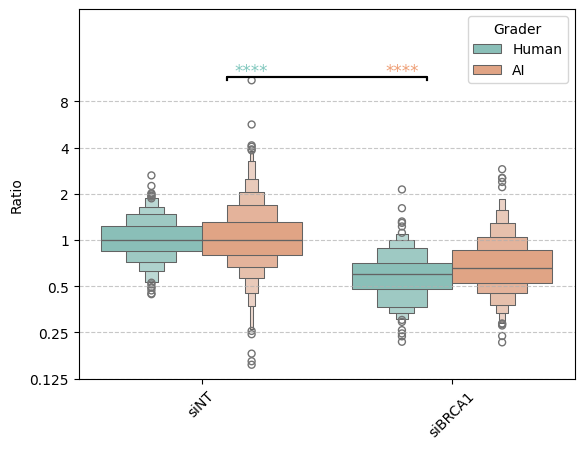

In [ ]:
df1_sint_sibrca1 = df1[df1['Ratio'] < 8]
df1_sint_sibrca1 = df1[df1['Ratio'] > 0.125]
df1_sint_sibrca1 = df1[df1['Valid']]
df1_sint_sibrca1 = df1_sint_sibrca1[(df1_sint_sibrca1['Type'] == 'siNT') | (df1_sint_sibrca1['Type'] == 'siBRCA1')]
normalize_df(df1_sint_sibrca1, 'siNT')
create_boxen_plot(df1_sint_sibrca1, palette=palette)
# graders_statistical_test(df_sint_sibrca1)
compare_pairs(df1_sint_sibrca1, palette=palette, pairs=[('siNT', 'siBRCA1', 5)])


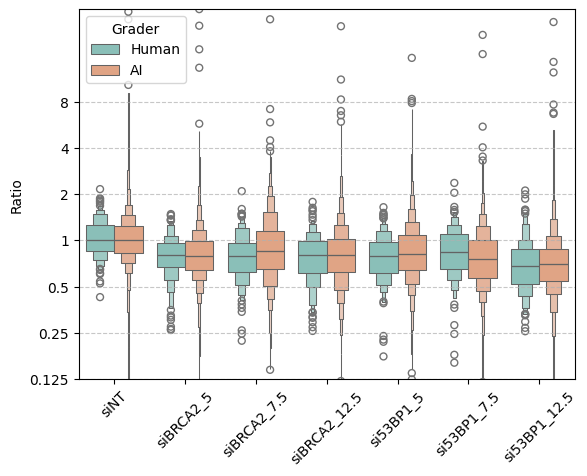

In [ ]:
df5_sint_sibrca1 = df5[df5['Ratio'] < 8]
df5_sint_sibrca1 = df5[df5['Ratio'] > 0.125]

df5_sint_sibrca1 = df5[df5['Valid']]
normalize_df(df5_sint_sibrca1, 'siNT')
create_boxen_plot(df5_sint_sibrca1, palette=palette)
# graders_statistical_test(df5_sint_sibrca1)
# compare_pairs(df5_sint_sibrca1, palette=palette, pairs=[('siNT', 'siBRCA1', 5)])


/tmp/ipykernel_525211/3359015576.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


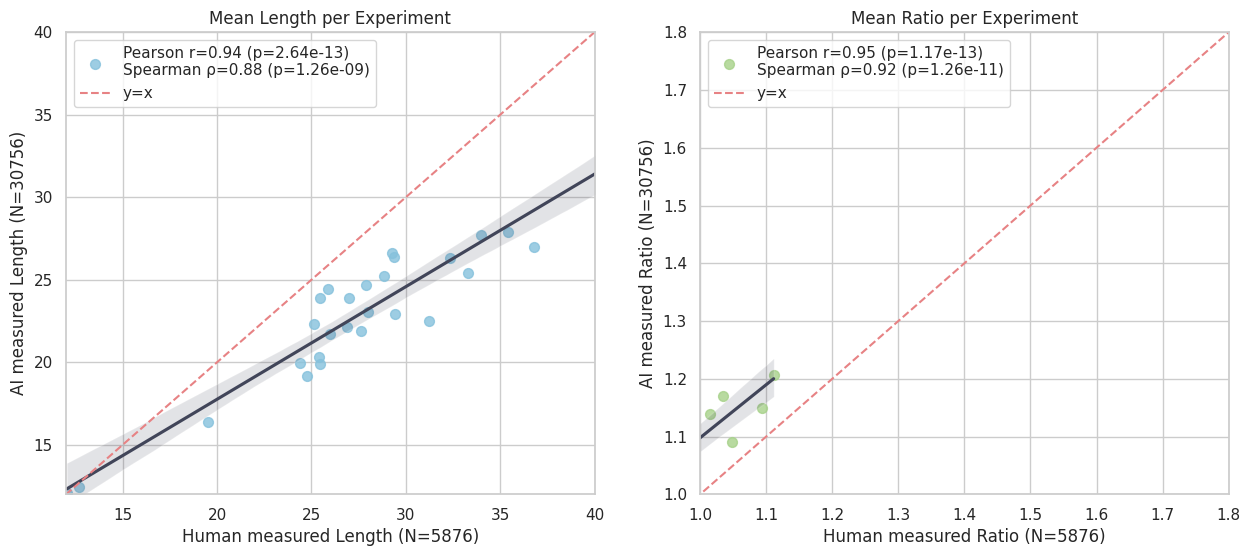

In [ ]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
x = df[df["Grader"] == "Human"]
y = df[df["Grader"] == "AI"]
grouped_x = x.groupby("Type")
grouped_y = y.groupby("Type")
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, (measure, yrange, color) in enumerate([("Length", (12, 40), "#85c1dc"), ("Ratio", (1, 1.8), "#a6d189")]):
    rho = pearsonr(grouped_x[f"{measure}"].mean(), grouped_y[f"{measure}"].mean())
    phi = spearmanr(grouped_x[f"{measure}"].mean(), grouped_y[f"{measure}"].mean())
    sns.regplot(x=grouped_x[f"{measure}"].mean(), y=grouped_y[f"{measure}"].mean(), 
                scatter_kws={"s": 50}, 
                line_kws={"color": "#414559"},
                color=color,
                label=f"Pearson r={rho[0]:.2f} (p={rho[1]:.2e})\nSpearman ρ={phi[0]:.2f} (p={phi[1]:.2e})",
                ax=axes[i])
    axes[i].set_xlabel(f"Human measured {measure} (N={len(x)})")
    axes[i].set_ylabel(f"AI measured {measure} (N={len(y)})")

    axes[i].set_title(f"Mean {measure} per Experiment")
    axes[i].plot([0, 40], [0, 40], color="#e78284", linestyle="--", label="y=x")
    axes[i].legend()

    axes[i].set_ylim(yrange)
    axes[i].set_xlim(yrange)

fig.show()
fig.savefig("figures/ai_vs_human_length_ratio.png", dpi=300)

In [ ]:
palette = ["#81c8be", "#ef9f76"]
g = sns.jointplot(data=df, 
                  x="Length", y="Ratio", 
                  hue="Grader",

                  kind="kde",
                  palette=palette, marginal_kws={"common_norm": False})
                #   common_norm=False, fill=True, multiple="stack", common_grid=True,)
g.plot_joint(sns.scatterplot, s=2, alpha=0.75)
plt.xlim(0, 60)
plt.ylim(0, 5)
plt.savefig("figures/length_vs_ratio_kde.png", dpi=300)

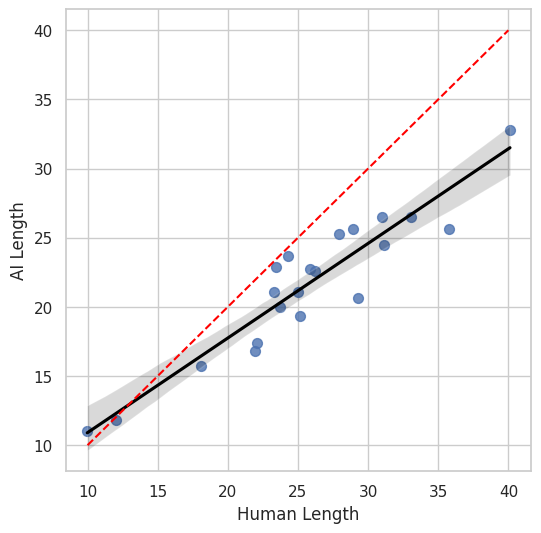

In [ ]:

df_groupped = df.groupby(["Grader", "Type"]).median()
x = df_groupped.xs("Human", level="Grader")
y = df_groupped.xs("AI", level="Grader")


sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 6))

sns.regplot(x=x["Length"], y=y["Length"], scatter_kws={"s": 50}, line_kws={"color": "black"})
plt.xlabel("Human Length")
plt.ylabel("AI Length")
plt.plot([10, 40], [10, 40], color="red", linestyle="--")
plt.show()

In [ ]:
len(df_groupped)

42

In [ ]:
df_groupped


Ratio   Length  Valid
Grader Type                                       
Human  MMS22L K0-1        1.702804  25.8530    1.0
       MMS22L K0-2        1.439087  28.8990    1.0
       U2OS-CTL           1.176156  27.9240    1.0
       si53BP1            1.377198  18.0890    1.0
       siBRCA1            0.870610  21.9380    1.0
       siBRCA2            1.416827  40.1125    1.0
       siMMS22L           0.945295   9.9795    1.0
       siMMS22L+C5        0.817219  12.0140    1.0
       siNT               1.617763  30.9720    1.0
       siNT+C5            1.426468  24.3190    1.0
       siTONSL            1.715072  23.7150    1.0
       siTONSL+si53BP1    1.582827  23.4515    1.0
       siTONSL-D          1.050790  22.0640    1.0
       siTONSL-D+siBRCA1  1.199576  23.3260    1.0
       siTONSL-D+siBRCA2  0.925581  25.1720    1.0
       siTONSL2 1.125     1.183147  29.2810    1.0
       siTONSL2 15        1.122013  35.7875    1.0
       siTONSL2 2.25      1.521995  31.1590    1.0
       siTONSL4 1.125     1.581570  33.0835    1.0
       siTONSL4 15        1.129664  26.2430    1.0
       siTONSL4 2.25      1.292278  25.0060    1.0
AI     MMS22L K0-1        1.710526  22.7500    1.0
       MMS22L K0-2        1.507945  25.6100    1.0
       U2OS-CTL           1.199174  25.2850    1.0
       si53BP1            1.424242  15.7300    1.0
       siBRCA1            1.000000  16.8350    1.0
       siBRCA2            1.512720  32.7600    1.0
       siMMS22L           1.220000  11.0500    1.0
       siMMS22L+C5        1.000000  11.8300    1.0
       siNT               1.603689  26.5200    1.0
       siNT+C5            1.552239  23.6600    1.0
       siTONSL            1.708204  20.0200    1.0
       siTONSL+si53BP1    1.666667  22.8800    1.0
       siTONSL-D          1.111111  17.4200    1.0
       siTONSL-D+siBRCA1  1.390244  21.0600    1.0
       siTONSL-D+siBRCA2  1.007169  19.3700    1.0
       siTONSL2 1.125     1.207870  20.6700    1.0
       siTONSL2 15        1.179587  25.6100    1.0
       siTONSL2 2.25      1.676222  24.4400    1.0
       siTONSL4 1.125     1.756757  26.5200    1.0
       siTONSL4 15        1.197045  22.6200    1.0
       siTONSL4 2.25      1.426448  21.0600    1.0